# Intro to Data Analysis
## Final Project: Investigate Data

In this project I will:
1. Choose a dataset (titanic, baseball)
2. Analyse the data
3. Make questions based on the analysis
4. Report found answers

## 1. Choose a dataset
I choose Baseball dataset because it represents a bigger challenge. Let's see what can I do.

In [256]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/home/david/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [257]:
def load_files(data_path, filenames):
    dfs = {}
    for f in filenames:
        parts = f.split('.')
        if parts[1] != 'csv':
            continue
        dfname = parts[0]
        absfilename = data_path + '/' + f
        dfs[dfname] = pd.read_csv(absfilename)
    return dfs

data_path = 'data/baseballdatabank-2017.1/core'
filenames = os.listdir(data_path)
dataframes = load_files(data_path, filenames)

## 2. Analyse data

In [258]:
print('Data Frames:')
display(sorted(dataframes.keys()))

Data Frames:


['AllstarFull',
 'Appearances',
 'AwardsManagers',
 'AwardsPlayers',
 'AwardsShareManagers',
 'AwardsSharePlayers',
 'Batting',
 'BattingPost',
 'CollegePlaying',
 'Fielding',
 'FieldingOF',
 'FieldingOFsplit',
 'FieldingPost',
 'HallOfFame',
 'HomeGames',
 'Managers',
 'ManagersHalf',
 'Master',
 'Parks',
 'Pitching',
 'PitchingPost',
 'Salaries',
 'Schools',
 'SeriesPost',
 'Teams',
 'TeamsFranchises',
 'TeamsHalf']

In [259]:
def describe_dataframes(dataframes):
    for df in dataframes:
        print(df)
        display(dataframes[df].describe())
        print('')

describe_dataframes(dataframes)

TeamsFranchises


,franchID,franchName,active,NAassoc
count,120,120,95,12
unique,120,99,2,12
top,CKK,Washington Nationals,N,NNA
freq,1,5,65,1



FieldingPost


,yearID,G,GS,InnOuts,PO,A,E,DP,TP,PB,SB,CS
count,12714.000000,12714.000000,12714.000000,12714.000000,12714.000000,12714.000000,12714.000000,12714.000000,12714.000000,1002.000000,1289.000000,1289.000000
mean,1987.339862,2.937471,2.136385,57.491269,6.387683,2.428583,0.186645,0.526270,0.000079,0.200599,0.670287,0.570985
std,27.306302,1.832593,2.221430,57.286623,11.235395,4.595591,0.522302,1.258644,0.008869,0.488304,1.438942,1.135862
min,1903.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1976.000000,1.000000,0.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1997.000000,3.000000,1.000000,29.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2007.000000,4.000000,4.000000,104.000000,8.000000,2.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
max,2016.000000,8.000000,8.000000,222.000000,91.000000,33.000000,8.000000,13.000000,1.000000,3.000000,15.000000,10.000000



Appearances


,yearID,G_all,GS,G_batting,G_defense,G_p,G_c,G_1b,G_2b,G_3b,G_ss,G_lf,G_cf,G_rf,G_of,G_dh,G_ph,G_pr
count,102761.000000,102761.000000,90166.000000,102761.000000,102761.000000,102761.000000,102761.000000,102761.000000,102761.000000,102761.000000,102761.000000,102761.000000,102761.000000,102761.000000,102761.000000,90166.000000,90166.000000,90166.000000
mean,1964.270219,51.380942,37.101601,48.417571,46.845243,10.362978,4.733615,4.588667,4.570304,4.587548,4.558850,4.840786,4.571005,4.702737,13.798708,1.260952,4.397167,0.806768
std,38.851188,47.126638,47.230209,48.889453,45.377191,16.963018,18.928323,20.713830,20.470539,20.325324,21.152432,19.019660,20.190575,19.296453,34.714992,8.443146,8.936892,2.521176
min,1871.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1934.000000,13.000000,1.000000,7.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1973.000000,34.000000,16.000000,31.000000,32.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1998.000000,80.000000,55.000000,80.000000,70.000000,17.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,5.000000,0.000000
max,2016.000000,165.000000,164.000000,165.000000,165.000000,106.000000,160.000000,162.000000,163.000000,164.000000,165.000000,163.000000,162.000000,162.000000,164.000000,162.000000,95.000000,92.000000



HomeGames


,year.key,games,openings,attendance
count,3006.000000,3006.000000,3006.000000,3.006000e+03
mean,1953.417498,70.960413,50.057219,1.107540e+06
std,42.949179,19.691534,33.037639,1.041145e+06
min,1871.000000,1.000000,0.000000,0.000000e+00
25%,1915.000000,74.000000,8.000000,6.055000e+04
50%,1961.000000,79.000000,67.000000,9.145680e+05
75%,1992.000000,81.000000,79.000000,1.858664e+06
max,2016.000000,89.000000,83.000000,4.483203e+06



SeriesPost


,yearID,wins,losses,ties
count,316.000000,316.000000,316.000000,316.000000
mean,1982.360759,3.550633,1.408228,0.009494
std,32.724093,0.801170,1.107462,0.097126
min,1884.000000,1.000000,0.000000,0.000000
25%,1970.750000,3.000000,0.000000,0.000000
50%,1995.000000,4.000000,1.000000,0.000000
75%,2007.000000,4.000000,2.000000,0.000000
max,2016.000000,10.000000,5.000000,1.000000



AwardsPlayers


,yearID
count,6158.000000
mean,1969.076648
std,30.841987
min,1877.000000
25%,1942.000000
50%,1975.000000
75%,1995.000000
max,2016.000000



AwardsShareManagers


,yearID,pointsWon,pointsMax,votesFirst
count,425.000000,425.000000,414.000000,425.000000
mean,2000.197647,40.117647,141.932367,4.567059
std,9.518527,41.601323,19.191283,7.057436
min,1983.000000,1.000000,24.000000,0.000000
25%,1992.000000,4.000000,140.000000,0.000000
50%,2000.000000,23.000000,140.000000,1.000000
75%,2009.000000,70.000000,150.000000,6.000000
max,2016.000000,154.000000,160.000000,30.000000



Parks


,park.key,park.name,park.alias,city,state,country
count,249,249,57,249,248,249
unique,249,239,56,84,35,6
top,STL02,Athletic Park,Federal League Park,Philadelphia,NY,US
freq,1,4,2,14,40,241



FieldingOFsplit


,yearID,stint,G,GS,InnOuts,PO,A,E,DP,PB,WP,SB,CS,ZR
count,31291.000000,31291.000000,31291.000000,20921.000000,20921.000000,21548.000000,21548.000000,21548.000000,21548.000000,0.0,0.0,0.0,0.0,0.0
mean,1988.649516,1.085296,28.832412,24.410019,656.014435,53.385140,1.667672,1.120893,0.344580,NaN,NaN,NaN,NaN,NaN
std,17.397249,0.295451,40.046401,38.857202,1023.007819,87.007142,3.052435,2.050349,0.839418,NaN,NaN,NaN,NaN,NaN
min,1954.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN
25%,1974.000000,1.000000,3.000000,1.000000,38.000000,3.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN
50%,1990.000000,1.000000,10.000000,6.000000,177.000000,14.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN
75%,2004.000000,1.000000,35.000000,27.000000,719.000000,57.000000,2.000000,1.000000,0.000000,NaN,NaN,NaN,NaN,NaN
max,2016.000000,4.000000,163.000000,163.000000,4438.000000,509.000000,30.000000,19.000000,9.000000,NaN,NaN,NaN,NaN,NaN



Fielding


,yearID,stint,G,GS,InnOuts,PO,A,E,DP,PB,WP,SB,CS,ZR
count,136815.000000,136815.000000,136815.000000,85273.000000,85273.000000,136815.000000,136814.000000,136813.000000,136814.000000,11230.000000,4189.000000,6138.000000,6138.000000,4189.000000
mean,1961.653349,1.076812,35.445792,26.680626,716.201693,83.385469,35.324265,3.859282,7.290058,5.147996,11.772977,24.859726,12.005865,0.703032
std,40.949885,0.282308,41.482180,40.731792,1067.250667,186.285168,79.618300,7.962017,19.616904,9.078281,12.249974,25.714221,13.155354,1.394882
min,1871.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1928.000000,1.000000,5.000000,0.000000,58.000000,2.000000,1.000000,0.000000,0.000000,0.000000,2.000000,4.000000,1.000000,0.000000
50%,1972.000000,1.000000,19.000000,7.000000,226.000000,10.000000,7.000000,1.000000,1.000000,2.000000,8.000000,17.000000,8.000000,0.000000
75%,1997.000000,1.000000,48.000000,32.000000,752.000000,75.000000,27.000000,4.000000,3.000000,6.000000,19.000000,39.000000,19.000000,1.000000
max,2016.000000,5.000000,165.000000,164.000000,4469.000000,1846.000000,641.000000,119.000000,194.000000,105.000000,69.000000,155.000000,89.000000,15.000000



TeamsHalf


,yearID,Half,Rank,G,W,L
count,52.0,52.000000,52.000000,52.000000,52.000000,52.000000
mean,1981.0,1.500000,3.692308,53.423077,26.711538,26.711538
std,0.0,0.504878,1.842190,2.872084,5.333345,5.184201
min,1981.0,1.000000,1.000000,48.000000,15.000000,20.000000
25%,1981.0,1.000000,2.000000,52.000000,23.000000,23.000000
50%,1981.0,1.500000,4.000000,53.000000,27.000000,26.000000
75%,1981.0,2.000000,5.000000,56.000000,31.000000,29.000000
max,1981.0,2.000000,7.000000,60.000000,37.000000,42.000000



Master


,birthYear,birthMonth,birthDay,deathYear,deathMonth,deathDay,weight,height
count,18973.000000,18803.000000,18656.000000,9441.000000,9440.000000,9439.000000,18251.000000,18320.000000
mean,1931.435356,6.629474,15.614816,1964.287364,6.483581,15.569552,186.375596,72.273799
std,41.555514,3.468103,8.750216,31.808030,3.529655,8.779552,21.524765,2.603904
min,1820.000000,1.000000,1.000000,1872.000000,1.000000,1.000000,65.000000,43.000000
25%,1895.000000,4.000000,8.000000,1942.000000,3.000000,8.000000,170.000000,71.000000
50%,1937.000000,7.000000,16.000000,1967.000000,6.000000,15.000000,185.000000,72.000000
75%,1969.000000,10.000000,23.000000,1990.000000,10.000000,23.000000,200.000000,74.000000
max,1996.000000,12.000000,31.000000,2017.000000,12.000000,31.000000,320.000000,83.000000



Batting


,yearID,stint,G,AB,R,H,2B,3B,HR,RBI,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP
count,102816.000000,102816.000000,102816.000000,102816.000000,102816.000000,102816.000000,102816.000000,102816.000000,102816.000000,102392.000000,101516.000000,79360.000000,102816.000000,94978.000000,66251.000000,100006.000000,96478.000000,66782.000000,76706.000000
mean,1964.262313,1.077838,51.343439,141.905511,18.815544,37.139930,6.289167,1.293252,2.813599,17.003975,2.976821,1.226008,13.067207,20.529712,1.105870,1.056057,2.299540,1.054101,2.981018
std,38.856297,0.284366,47.121658,184.654492,28.242983,52.603757,9.662468,2.645770,6.304919,26.352011,7.717174,2.747377,20.746460,28.328542,2.780187,2.276251,4.241095,1.961732,4.735153
min,1871.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1934.000000,1.000000,13.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1973.000000,1.000000,34.000000,49.000000,4.000000,9.000000,1.000000,0.000000,0.000000,3.000000,0.000000,0.000000,3.000000,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1998.000000,1.000000,80.000000,231.000000,27.000000,58.000000,9.000000,1.000000,2.000000,24.000000,2.000000,1.000000,18.000000,29.000000,1.000000,1.000000,3.000000,1.000000,4.000000
max,2016.000000,5.000000,165.000000,716.000000,192.000000,262.000000,67.000000,36.000000,73.000000,191.000000,138.000000,42.000000,232.000000,223.000000,120.000000,51.000000,67.000000,19.000000,36.000000



BattingPost


,yearID,G,AB,R,H,2B,3B,HR,RBI,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP
count,13543.000000,13543.00000,13543.000000,13543.000000,13543.000000,13543.000000,13543.000000,13543.000000,13543.000000,13543.000000,13342.00000,13543.000000,13543.000000,13543.000000,13342.000000,13342.000000,13342.000000,13342.000000
mean,1985.506904,3.13771,7.803072,0.929041,1.895149,0.331094,0.048660,0.193679,0.862438,0.149967,0.06903,0.733442,1.488740,0.081223,0.063109,0.104257,0.049393,0.148329
std,29.683760,1.88720,8.878143,1.528511,2.625735,0.705140,0.236422,0.532574,1.574862,0.573527,0.29327,1.300220,1.965664,0.348283,0.271150,0.365269,0.233992,0.419295
min,1884.000000,1.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1974.000000,2.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1997.000000,3.00000,3.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2007.000000,4.00000,15.000000,1.000000,3.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.00000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,2016.000000,15.00000,66.000000,13.000000,21.000000,6.000000,4.000000,6.000000,13.000000,15.000000,5.00000,13.000000,13.000000,7.000000,4.000000,5.000000,3.000000,5.000000



AllstarFull


,yearID,gameNum,GP,startingPos
count,5148.000000,5148.000000,5129.000000,1600.000000
mean,1977.040210,0.134810,0.777929,5.031250
std,24.008874,0.458167,0.415679,2.657007
min,1933.000000,0.000000,0.000000,0.000000
25%,1958.000000,0.000000,1.000000,3.000000
50%,1977.000000,0.000000,1.000000,5.000000
75%,1999.000000,0.000000,1.000000,7.000000
max,2016.000000,2.000000,1.000000,10.000000



PitchingPost


,yearID,W,L,G,GS,CG,SHO,SV,IPouts,H,...,IBB,WP,HBP,BK,BFP,GF,R,SH,SF,GIDP
count,5271.000000,5271.000000,5271.000000,5271.000000,5271.000000,5271.000000,5271.000000,5271.000000,5271.000000,5271.000000,...,5221.000000,5221.000000,5221.000000,5221.000000,5221.000000,5271.000000,5271.000000,5221.000000,5221.000000,5221.000000
mean,1988.439385,0.297097,0.297097,1.914437,0.596471,0.125213,0.027130,0.109467,16.011383,4.869285,...,0.210688,0.145566,0.161272,0.013024,21.838154,0.471258,2.388162,0.266424,0.126221,0.379046
std,27.602733,0.558995,0.531859,1.014170,0.808481,0.474263,0.170456,0.420950,15.247467,4.748613,...,0.495235,0.412768,0.418950,0.113389,18.616765,0.838970,2.772179,0.605278,0.367715,0.689392
min,1884.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1978.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2.000000,...,0.000000,0.000000,0.000000,0.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1998.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,12.000000,4.000000,...,0.000000,0.000000,0.000000,0.000000,17.000000,0.000000,2.000000,0.000000,0.000000,0.000000
75%,2008.000000,1.000000,1.000000,2.000000,1.000000,0.000000,0.000000,0.000000,21.000000,7.000000,...,0.000000,0.000000,0.000000,0.000000,28.000000,1.000000,4.000000,0.000000,0.000000,1.000000
max,2016.000000,4.000000,4.000000,8.000000,8.000000,8.000000,3.000000,4.000000,213.000000,64.000000,...,4.000000,5.000000,3.000000,1.000000,178.000000,6.000000,36.000000,7.000000,4.000000,6.000000



Schools


,schoolID,name_full,city,state,country
count,1207,1207,1207,1207,1207
unique,1207,1199,856,49,1
top,mdbalcc,St. Joseph's College,Chicago,CA,USA
freq,1,2,9,136,1207



Pitching


,yearID,stint,W,L,G,GS,CG,SHO,SV,IPouts,...,IBB,WP,HBP,BK,BFP,GF,R,SH,SF,GIDP
count,44963.000000,44963.000000,44963.000000,44963.000000,44963.000000,44963.000000,44963.000000,44963.000000,44963.000000,44963.000000,...,30388.000000,44830.000000,44405.000000,44963.000000,44724.000000,44830.000000,44963.000000,12063.000000,12063.000000,12061.000000
mean,1968.670062,1.079643,4.715744,4.715722,23.681761,9.485488,3.151035,0.448591,1.504793,253.872139,...,2.411379,2.528575,2.266096,0.301604,343.312181,6.345260,43.021773,2.141922,1.878388,5.322610
std,37.569499,0.284834,5.813410,4.988846,18.493488,12.283920,7.081844,1.109742,4.991518,257.330446,...,2.772648,3.425706,2.998881,0.755523,348.758261,9.993949,43.245812,2.710191,2.121352,5.990178
min,1871.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1941.000000,1.000000,0.000000,1.000000,7.000000,0.000000,0.000000,0.000000,0.000000,49.000000,...,0.000000,0.000000,0.000000,0.000000,64.000000,0.000000,11.000000,0.000000,0.000000,1.000000
50%,1978.000000,1.000000,2.000000,3.000000,21.000000,3.000000,0.000000,0.000000,0.000000,167.000000,...,2.000000,1.000000,1.000000,0.000000,227.000000,3.000000,28.000000,1.000000,1.000000,3.000000
75%,2001.000000,1.000000,7.000000,8.000000,35.000000,17.000000,3.000000,0.000000,1.000000,393.000000,...,4.000000,4.000000,3.000000,0.000000,535.000000,8.000000,67.000000,3.000000,3.000000,8.000000
max,2016.000000,4.000000,59.000000,48.000000,106.000000,75.000000,75.000000,16.000000,62.000000,2040.000000,...,23.000000,63.000000,41.000000,16.000000,2906.000000,84.000000,519.000000,21.000000,14.000000,40.000000



FieldingOF


,yearID,stint,Glf,Gcf,Grf
count,12028.000000,12028.000000,11991.000000,11991.000000,11985.000000
mean,1912.736448,1.086548,15.740639,15.574598,15.755695
std,23.723650,0.306644,33.289793,34.599550,33.078331
min,1871.000000,1.000000,0.000000,0.000000,0.000000
25%,1891.000000,1.000000,0.000000,0.000000,0.000000
50%,1912.000000,1.000000,1.000000,1.000000,1.000000
75%,1933.000000,1.000000,11.000000,8.000000,11.000000
max,1955.000000,5.000000,156.000000,162.000000,160.000000



HallOfFame


,yearid,ballots,needed,votes
count,4156.000000,3961.000000,3804.000000,3961.000000
mean,1969.306304,321.746529,244.776551,51.465791
std,23.231639,125.455368,94.497219,85.473954
min,1936.000000,78.000000,59.000000,0.000000
25%,1950.000000,226.000000,175.000000,2.000000
50%,1966.000000,274.000000,213.000000,10.000000
75%,1988.000000,427.000000,323.000000,64.000000
max,2017.000000,581.000000,436.000000,555.000000



Salaries


,yearID,salary
count,26428.000000,2.642800e+04
mean,2000.878727,2.085634e+06
std,8.909314,3.455348e+06
min,1985.000000,0.000000e+00
25%,1994.000000,2.947020e+05
50%,2001.000000,5.500000e+05
75%,2009.000000,2.350000e+06
max,2016.000000,3.300000e+07



Teams


,yearID,Rank,G,Ghome,W,L,R,AB,H,2B,...,HA,HRA,BBA,SOA,E,DP,FP,attendance,BPF,PPF
count,2835.000000,2835.000000,2835.000000,2436.000000,2835.000000,2835.000000,2835.000000,2835.000000,2835.000000,2835.000000,...,2835.000000,2835.000000,2835.000000,2835.000000,2835.000000,2518.000000,2835.000000,2.556000e+03,2835.000000,2835.000000
mean,1955.681834,4.095238,150.469841,78.496305,74.814109,74.814109,682.399295,5146.473369,1346.939330,228.127690,...,1346.751675,102.045150,474.316755,737.241623,185.365432,140.237490,0.965447,1.357173e+06,100.197531,100.223280
std,41.767356,2.318674,23.134065,4.677657,17.591208,17.331455,135.224393,747.595825,218.926978,58.633383,...,218.656539,58.648758,131.328309,300.673368,107.508483,29.218873,0.029437,9.510391e+05,4.903349,4.834146
min,1871.000000,1.000000,6.000000,44.000000,0.000000,4.000000,24.000000,211.000000,33.000000,3.000000,...,49.000000,0.000000,0.000000,0.000000,47.000000,18.000000,0.765000,6.088000e+03,60.000000,60.000000
25%,1920.000000,2.000000,154.000000,77.000000,66.000000,65.000000,614.000000,5132.000000,1300.000000,193.500000,...,1289.000000,47.000000,429.000000,503.000000,116.000000,127.000000,0.965000,5.348265e+05,97.000000,97.000000
50%,1964.000000,4.000000,157.000000,81.000000,77.000000,76.000000,690.000000,5395.000000,1393.000000,231.000000,...,1392.000000,110.000000,494.000000,740.000000,145.000000,145.000000,0.976000,1.154750e+06,100.000000,100.000000
75%,1993.000000,6.000000,162.000000,81.000000,87.000000,87.000000,763.000000,5518.000000,1467.000000,271.000000,...,1470.000000,150.000000,554.000000,972.000000,215.000000,159.000000,0.981000,2.042453e+06,103.000000,103.000000
max,2016.000000,13.000000,165.000000,84.000000,116.000000,134.000000,1220.000000,5781.000000,1783.000000,376.000000,...,1993.000000,258.000000,827.000000,1510.000000,639.000000,217.000000,0.991000,4.483350e+06,129.000000,141.000000



Managers


,yearID,inseason,G,W,L,rank
count,3436.000000,3436.000000,3436.000000,3436.000000,3436.000000,3435.000000
mean,1954.223516,1.233120,124.168510,61.729627,61.738068,4.339738
std,42.078606,0.596025,50.414981,28.746768,26.417168,2.396520
min,1871.000000,1.000000,1.000000,0.000000,0.000000,1.000000
25%,1918.000000,1.000000,91.000000,42.000000,46.000000,2.000000
50%,1962.000000,1.000000,154.000000,70.000000,68.000000,4.000000
75%,1991.000000,1.000000,162.000000,84.000000,81.000000,6.000000
max,2016.000000,9.000000,165.000000,116.000000,120.000000,12.000000



AwardsSharePlayers


,yearID,pointsWon,pointsMax,votesFirst
count,6879.000000,6879.000000,6879.000000,6521.000000
mean,1972.461259,43.559674,267.518389,1.624751
std,27.707848,68.265957,128.988138,4.911428
min,1911.000000,0.000000,16.000000,0.000000
25%,1950.000000,4.000000,140.000000,0.000000
50%,1975.000000,12.000000,336.000000,0.000000
75%,1996.000000,53.000000,336.000000,0.000000
max,2016.000000,448.000000,448.000000,32.000000



AwardsManagers


,yearID
count,179.000000
mean,1988.921788
std,20.872123
min,1936.000000
25%,1980.500000
50%,1994.000000
75%,2005.000000
max,2016.000000



CollegePlaying


,yearID
count,17350.000000
mean,1969.490259
std,32.783259
min,1864.000000
25%,1949.000000
50%,1981.000000
75%,1995.000000
max,2014.000000



ManagersHalf


,yearID,inseason,half,G,W,L,rank
count,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000
mean,1947.505376,1.387097,1.483871,49.784946,24.645161,24.645161,5.161290
std,43.351351,0.752276,0.502448,19.150916,12.218700,9.389686,3.194051
min,1892.000000,1.000000,1.000000,2.000000,0.000000,2.000000,1.000000
25%,1892.000000,1.000000,1.000000,47.000000,16.000000,21.000000,3.000000
50%,1981.000000,1.000000,1.000000,53.000000,25.000000,25.000000,5.000000
75%,1981.000000,2.000000,2.000000,57.000000,31.000000,30.000000,7.000000
max,1981.000000,5.000000,2.000000,80.000000,53.000000,46.000000,12.000000


In [260]:
print('Main table')
dataframes['Master'].head()

Main table


,playerID,birthYear,birthMonth,birthDay,birthCountry,birthState,birthCity,deathYear,deathMonth,deathDay,...,nameLast,nameGiven,weight,height,bats,throws,debut,finalGame,retroID,bbrefID
0,aardsda01,1981.0,12.0,27.0,USA,CO,Denver,NaN,NaN,NaN,...,Aardsma,David Allan,215.0,75.0,R,R,2004-04-06,2015-08-23,aardd001,aardsda01
1,aaronha01,1934.0,2.0,5.0,USA,AL,Mobile,NaN,NaN,NaN,...,Aaron,Henry Louis,180.0,72.0,R,R,1954-04-13,1976-10-03,aaroh101,aaronha01
2,aaronto01,1939.0,8.0,5.0,USA,AL,Mobile,1984.0,8.0,16.0,...,Aaron,Tommie Lee,190.0,75.0,R,R,1962-04-10,1971-09-26,aarot101,aaronto01
3,aasedo01,1954.0,9.0,8.0,USA,CA,Orange,NaN,NaN,NaN,...,Aase,Donald William,190.0,75.0,R,R,1977-07-26,1990-10-03,aased001,aasedo01
4,abadan01,1972.0,8.0,25.0,USA,FL,Palm Beach,NaN,NaN,NaN,...,Abad,Fausto Andres,184.0,73.0,L,L,2001-09-10,2006-04-13,abada001,abadan01


In [261]:
print('Batting table')
dataframes['Batting'].head()

Batting table


,playerID,yearID,stint,teamID,lgID,G,AB,R,H,2B,...,RBI,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP
0,abercda01,1871,1,TRO,NaN,1,4,0,0,0,...,0.0,0.0,0.0,0,0.0,NaN,NaN,NaN,NaN,NaN
1,addybo01,1871,1,RC1,NaN,25,118,30,32,6,...,13.0,8.0,1.0,4,0.0,NaN,NaN,NaN,NaN,NaN
2,allisar01,1871,1,CL1,NaN,29,137,28,40,4,...,19.0,3.0,1.0,2,5.0,NaN,NaN,NaN,NaN,NaN
3,allisdo01,1871,1,WS3,NaN,27,133,28,44,10,...,27.0,1.0,1.0,0,2.0,NaN,NaN,NaN,NaN,NaN
4,ansonca01,1871,1,RC1,NaN,25,120,29,39,11,...,16.0,6.0,2.0,2,1.0,NaN,NaN,NaN,NaN,NaN


In [262]:
print('Pitching table')
dataframes['Pitching'].head()

Pitching table


,playerID,yearID,stint,teamID,lgID,W,L,G,GS,CG,...,IBB,WP,HBP,BK,BFP,GF,R,SH,SF,GIDP
0,bechtge01,1871,1,PH1,NaN,1,2,3,3,2,...,NaN,NaN,NaN,0,NaN,NaN,42,NaN,NaN,NaN
1,brainas01,1871,1,WS3,NaN,12,15,30,30,30,...,NaN,NaN,NaN,0,NaN,NaN,292,NaN,NaN,NaN
2,fergubo01,1871,1,NY2,NaN,0,0,1,0,0,...,NaN,NaN,NaN,0,NaN,NaN,9,NaN,NaN,NaN
3,fishech01,1871,1,RC1,NaN,4,16,24,24,22,...,NaN,NaN,NaN,0,NaN,NaN,257,NaN,NaN,NaN
4,fleetfr01,1871,1,NY2,NaN,0,1,1,1,1,...,NaN,NaN,NaN,0,NaN,NaN,21,NaN,NaN,NaN


In [263]:
print('Fielding table')
dataframes['Fielding'].head()

Fielding table


,playerID,yearID,stint,teamID,lgID,POS,G,GS,InnOuts,PO,A,E,DP,PB,WP,SB,CS,ZR
0,abercda01,1871,1,TRO,NaN,SS,1,NaN,NaN,1,3.0,2.0,0.0,NaN,NaN,NaN,NaN,NaN
1,addybo01,1871,1,RC1,NaN,2B,22,NaN,NaN,67,72.0,42.0,5.0,NaN,NaN,NaN,NaN,NaN
2,addybo01,1871,1,RC1,NaN,SS,3,NaN,NaN,8,14.0,7.0,0.0,NaN,NaN,NaN,NaN,NaN
3,allisar01,1871,1,CL1,NaN,2B,2,NaN,NaN,1,4.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
4,allisar01,1871,1,CL1,NaN,OF,29,NaN,NaN,51,3.0,7.0,1.0,NaN,NaN,NaN,NaN,NaN


## 3. Make questions
After analysing the tables for a while, I came up with the following questions, which I expect to answer underneath:

1. Which school did winners go to?
2. Did winners get highest salaries?
3. Were winners right or left handed?
4. Is there a correlation between winning teams and managers?

## 4. Report found answers

To answer any question about winners first I'll define a winner. Since baseball is a team game I'll say that a winner is a player who participated on the biggest amount of winning teams.

Teams by Wins (whole population)


,yearID,W
count,2835.000000,2835.000000
mean,1955.681834,74.814109
std,41.767356,17.591208
min,1871.000000,0.000000
25%,1920.000000,66.000000
50%,1964.000000,77.000000
75%,1993.000000,87.000000
max,2016.000000,116.000000


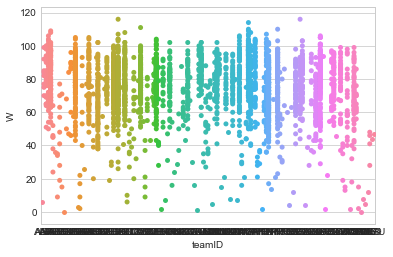

In [270]:
team_wins_by_year = dataframes['Teams'].groupby(['teamID', 'yearID'], as_index=False)['teamID', 'W'].sum()
team_wins_by_year.sort_values('W', ascending=False).describe()
print('Teams by Yearly Wins (whole population)')
display(team_wins_by_year.describe())
sns.stripplot(x="teamID", y="W", data=team_wins_by_year)

#### Problem
There is no direct relationship between players and teams. It means that I will have to find games first. This is possible using the Appearences table.

Teams by Wins


,W
count,149.000000
mean,1423.476510
std,2649.598666
min,0.000000
25%,43.000000
50%,118.000000
75%,1373.000000
max,10711.000000


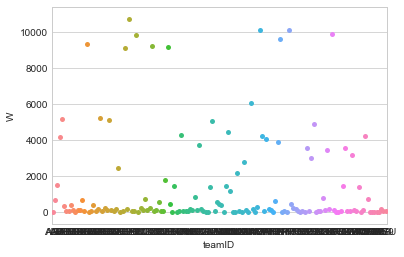

In [271]:
print('Teams by Wins')
teams_wins = team_wins_by_year.groupby('teamID', as_index=False)['W'].sum()
display(teams_wins.sort_values('W', ascending=False).describe())
sns.stripplot(x="teamID", y="W", data=teams_wins)

In [163]:
p = teams_appearences.groupby(['playerID', 'teamID'], as_index=False)[['playerID', 'teamID', 'W']].sum()

players_w = p.groupby('playerID', as_index=False).sum().sort_values('W', ascending=False)
players_winners = players_w[players_w['W'] > 2000]
teams_w = p.groupby('teamID', as_index=False).sum().sort_values('W', ascending=False)
teams_winners = teams_w[teams_w['W'] > 250000]

Winner Players


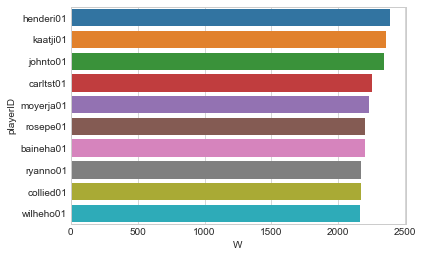

In [162]:
print('Winner Players')
sns.set_style("whitegrid")
sns.barplot(y='playerID', x='W', data=players_winners.iloc[0:10], estimator=np.max)

In [283]:
print('Best player teams')
best_player_teams = teams_appearences[teams_appearences['playerID'] == 'henderi01']['teamID'].unique()
display(best_player_teams)

Best player teams


array(['ANA', 'BOS', 'LAN', 'NYA', 'NYN', 'OAK', 'SDN', 'SEA', 'TOR'], dtype=object)

In [238]:
# winner teams compared to winner player's teams
#display(teams_winners)
players_winners_teams = teams_appearences.merge(players_winners, on='playerID', how='inner').groupby('teamID', as_index=False)
display(players_winners_teams)
#f, ax = plt.subplots(figsize=(6, 6))
#sns.set_color_codes("pastel")
#sns.barplot(y='teamID', x='W', data=teams_winners.iloc[0:10], label='Winner Teams - Top 10', color='b')

#sns.set_color_codes("muted")
#sns.barplot(y='teamID', x='W', data=players_winners_teams, label='Winner Player Teams - Top 10', color='b')

#ax.legend(ncol=2, loc="lower right", frameon=True)
#ax.set(xlim=(0, 24), ylabel="", xlabel="Winner Teams vs. Winner Player Teams")
#sns.despine(left=True, bottom=True)


In [193]:
#pw = players_winners['playerID'].values

sns.barplot(x='', y='', data=players_winners_teams)

,teamID,0
0,ANA,1
1,ARI,1
2,ATL,52
3,BAL,68
4,BOS,54
5,BRO,10
6,CAL,19
7,CHA,66
8,CHN,33
9,CIN,44


It seems that most winners were born between 1940 and 1960:


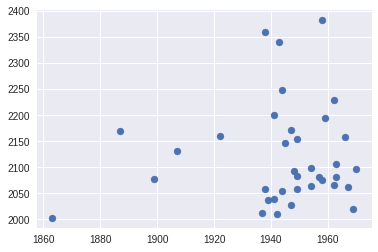

In [12]:
print('It seems that most winners were born between 1940 and 1960:')
winners_players = dataframes['Master'].merge(winners, on='playerID', how='right')
plt.scatter(winners_players['birthYear'], winners_players['W'])

## Question 1
### Which school did winners go to?
Surprisingly, the best player regarding games played in winning teams, does not report school, as you can see below. But after dropping players without reported school it seems that top5 schools are the ones listed underneath:

In [13]:
winners_with_schools = winners_players.merge(dataframes['CollegePlaying'], on='playerID', how='left')
winners_schools = winners_with_schools[['playerID', 'nameGiven', 'schoolID', 'yearID', 'W']].sort_values('W', ascending=False).dropna().groupby('schoolID')

In [14]:
#plt.hist(winners_schools['schoolID'].count())
top5_schools = winners_schools['schoolID'].count().sort_values(ascending=False)[0:5]
display(top5_schools)

schoolID
wlibertyst    3
stjosephs     3
mariettaoh    3
columbia      3
texas         2
Name: schoolID, dtype: int64

## Question 2
### Did winners get highest salaries?
Apparently participating the more winning games doesn't have a strict correlation with highest salaries, but they are still in the massive salaries list.
To calculate the salaries, I took the maximum salary for each player/team.

As you can see underneath, highest salaries didn't go to players of winning teams with the largest amount of goals.
Instead, a group of players related to teams with about 2000 to 2200 goals got higher salaries than the team with 2382 goals.

,playerID,teamID,salary,yearID,W
47,clemero02,HOU,18000000.0,2005.0,2067
304,thomeji01,CHA,15666666.0,2008.0,2097
303,thomeji01,CHA,14833333.0,2007.0,2097
227,maddugr01,ATL,14750000.0,2003.0,2159
302,thomeji01,CHA,14166667.0,2006.0,2097


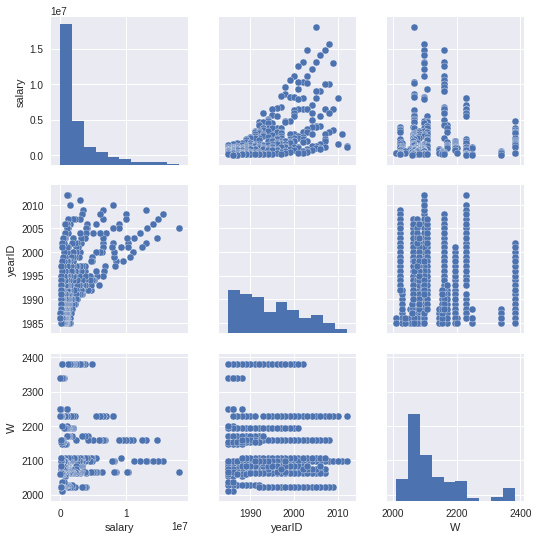

In [15]:
def calculate_mean_salary(col):
    count = col.count()
    return ((1/count)*col['salary'].sum())/1000
winners_salaries = dataframes['Salaries'].merge(winners, on='playerID', how='right')[['playerID', 'teamID', 'salary', 'yearID', 'W']].dropna().sort_values(['salary'], ascending=False)
winners_salary_mean_1000x = winners_salaries.groupby('playerID').apply(calculate_mean_salary)
winners_salary_max = winners_salaries.groupby('playerID').max()
winners_salary_max.sort_values('salary', ascending=False)
sns.pairplot(winners_salaries)
winners_salaries.head()

## Question 3
### Were winners right or left handed?
Or maybe both, either to bat or throw? It seems like most of them are right-handed as you can see in the chart below.

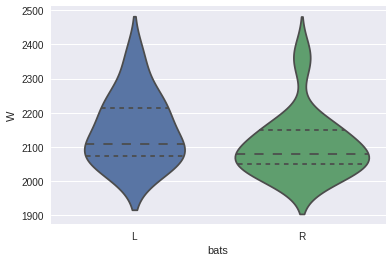

In [16]:
winners_left_right_counts = winners_players.groupby(['bats', 'throws'])[['bats', 'throws']].count()
#display(winners_left_right_counts)
#winners_players.groupby(['throws'])['throws']
sns.violinplot(x="bats", y="W", data=winners_players[winners_players['bats'] != 'B'], split=True, inner="quart")

## Question 4
### Is there a correlation between winning teams and managers?
As I notice, every year the team can have a different manager. This means that *year* is a variable to take into account.

In [25]:
#display(winners_players.merge(dataframes['Managers'], on='playerID', how='inner').groupby(['teamID', 'yearID']).head())
manager_team_year = dataframes['Managers'].groupby(['teamID', 'yearID'])['playerID', 'teamID', 'yearID']
display(dataframes['Managers'][['playerID', 'yearID', 'teamID', 'W']].sort_values('W', ascending=False))

,playerID,yearID,teamID,W
634,chancfr01,1906,CHN,116
2904,pinielo01,2001,SEA,116
2806,torrejo01,1998,NYA,114
1531,lopezal01,1954,CLE,111
693,clarkfr01,1909,PIT,110
1025,huggimi01,1927,NYA,110
1876,weaveea99,1969,BAL,109
1679,houkra01,1961,NYA,109
2069,andersp01,1975,CIN,108
2440,johnsda02,1986,NYN,108


In [21]:
# display(manager_team_year.head())
dataframes['Managers'].columns

Index(['playerID', 'yearID', 'teamID', 'lgID', 'inseason', 'G', 'W', 'L',
       'rank', 'plyrMgr'],
      dtype='object')